# Online Retail Data Exploration

This notebook captures the exploratory analysis that would inform the design of the assessment pipeline. It shows our data quality baselines, documents business rules, and highlights questions that the downstream model would support.


## Notebook Roadmap

1. **Introduction** – Context, objectives, and dataset overview.
2. **Exploratory Data Analysis (EDA)** – Initial profiling, data distributions, and key quality findings.
3. **Data Understanding & Wrangling** – Deriving business rules, feature checks, and structural insights.
4. **Data Cleaning Strategy** – Transformations applied, before/after metrics, and retained records.
5. **Conclusion & Next Steps** – How findings drive the production pipeline design.


## 1. Introduction

The UCI Online Retail dataset captures 12 months of transactions for a UK-based ecommerce retailer. Each row represents a line item on an invoice, with descriptive columns for stock code, description, unit price, customer identifiers, and the invoice timestamp. The goal of this notebook is to:

- Validate the raw Excel extract ahead of the actual data pipeline.
- Identify data quality gaps (missing values, negative quantities, negative prices, duplicates).
- Define business rules that the production pipeline can then enforce.
- Gauge the analytical potential that informs the dimensional model.


## 0. Notebook Setup

This analysis from our google collab would be added into our CaseStudy repository structure:

- Raw data: `data/online_retail.xlsx`
- Outputs: `models/`, `docs/`, and `sql/`


In [104]:
%%capture
%pip install ydata-profiling seaborn gdown

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import logging
from ydata_profiling import ProfileReport

from pathlib import Path

import gdown

sns.set_theme(style="whitegrid")

In [106]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.FileHandler("pipeline.log", mode="w"), logging.StreamHandler()]
)

In [107]:
logger = logging.getLogger()

In [108]:
gdown.download(id="1NicvRmwc45R4olrDRLUhsOAUfRjwampK", output="online_retail.xlsx", quiet=True)

#considering someone might want to run this code, I have used gdown for reproducability

'online_retail.xlsx'

In [109]:
DATA_PATH = Path("/content/online_retail.xlsx")

In [110]:
try:
    logger.info("Reading input Excel file: %s", DATA_PATH)
    df_raw = pd.read_excel(DATA_PATH)
    logger.info("Loaded data with shape %s", df_raw.shape)
except Exception as exc:
    logger.exception("Failed to read Excel file")
    raise exc

#t-e block to log reading data

## 2. Exploratory Data Analysis (EDA)

We begin by validating the raw extract, inspecting missing values, and noting business-rule violations that will guide our pipeline logic.


In [111]:
df_raw.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [112]:
summary_metrics = pd.DataFrame({
    "metric": ["Rows", "Columns", "Date range", "Distinct invoices", "Distinct customers", "Distinct products"],
    "value": [
        f"{len(df_raw):,}",
        df_raw.shape[1],
        f"{df_raw['InvoiceDate'].min():%d-%b-%Y} to {df_raw['InvoiceDate'].max():%d-%b-%Y}",
        df_raw['InvoiceNo'].nunique(),
        df_raw['CustomerID'].nunique(),
        df_raw['StockCode'].nunique()
    ]
})
summary_metrics


,metric,value
0,Rows,"541,909"
1,Columns,8
2,Date range,01-Dec-2010 to 09-Dec-2011
3,Distinct invoices,25900
4,Distinct customers,4372
5,Distinct products,4070


**Dataset summary:** 541k invoice lines across 8 columns spanning 01-Dec-2010 to 09-Dec-2011, covering 26k invoices and ~4k products.


In [113]:
df_raw.isna().sum().sort_values(ascending=False)

#investigating Nans in columns

,0
CustomerID,135080
Description,1454
StockCode,0
InvoiceNo,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


/tmp/ipython-input-3914752090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_pct, x="missing_pct", y="column", palette="Blues_r")


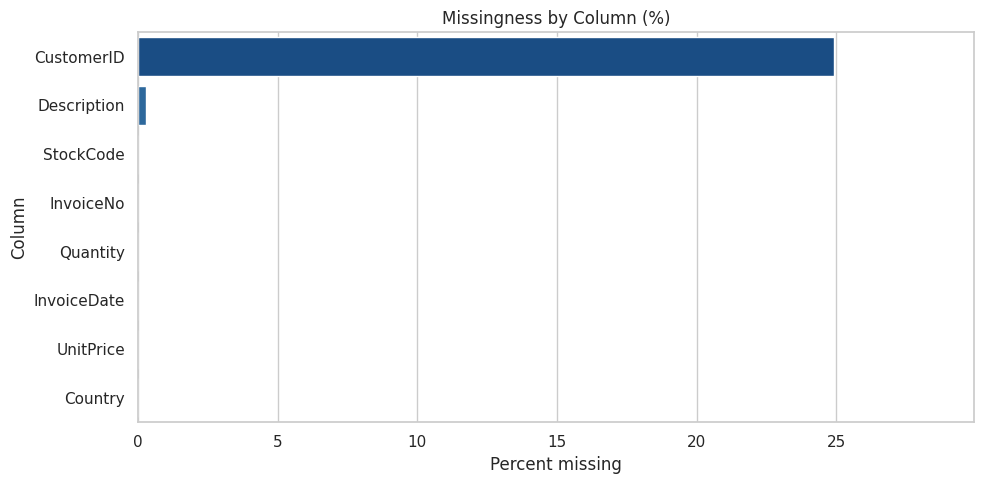

In [114]:
missing_pct = (df_raw.isna().sum().sort_values(ascending=False) / len(df_raw) * 100).reset_index()
missing_pct.columns = ["column", "missing_pct"]

plt.figure(figsize=(10, 5))
sns.barplot(data=missing_pct, x="missing_pct", y="column", palette="Blues_r")
plt.title("Missingness by Column (%)")
plt.xlabel("Percent missing")
plt.ylabel("Column")
plt.xlim(0, missing_pct["missing_pct"].max() + 5)
plt.tight_layout()
plt.show()

missing_pct;

In [115]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Key quality flags:** Nearly 25% of ALL rows lack a `CustomerID`, with much smaller gaps elsewhere. This reinforces the need to somehow work on customer keys before loading facts.

**Anomaly sizing:** Negative quantities (returns) and zero-priced lines represent a limited share of rows but must be isolated to avoid overstating revenue.



In [141]:
anomaly_metrics = pd.DataFrame({
    "rule": [
        "Quantity < 0",
        "UnitPrice <= 0",
        "Missing CustomerID",
        "Duplicate InvoiceNo+StockCode+InvoiceDate"
    ],
    "records": [
        int((df_raw["Quantity"] < 0).sum()),
        int((df_raw["UnitPrice"] <= 0).sum()),
        int(df_raw["CustomerID"].isna().sum()),
        int(df_raw.duplicated(subset=["InvoiceNo", "StockCode", "InvoiceDate"]).sum())
    ]
})
anomaly_metrics


,rule,records
0,Quantity < 0,10624
1,UnitPrice <= 0,2517
2,Missing CustomerID,135080
3,Duplicate InvoiceNo+StockCode+InvoiceDate,10677


**Feature engineering preview:** Calculated `LineTotal` (Quantity × UnitPrice) becomes the measure in the fact table; `InvoiceDate` conversion enables surrogate date keys.


## 3. Data Understanding & Wrangling

Here we check key features, derive helpers, and explore the business rules that will become the constraints of the pipeline.


**Customer & geography insight:** The UK dominates revenue, but the other European markets motivates retaining `Country`.


In [117]:
df_raw['Country'].value_counts().head(10)

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [118]:
df_features = df_raw.copy()
df_features["InvoiceDate"] = pd.to_datetime(df_features["InvoiceDate"])
df_features["LineTotal"] = df_features["Quantity"] * df_features["UnitPrice"]
df_features["InvoiceDateDate"] = df_features["InvoiceDate"].dt.date

df_features[["InvoiceDate", "LineTotal"]].head()


,InvoiceDate,LineTotal
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34


In [119]:
country_revenue = (
    df_features.groupby("Country")
    .agg(
        invoices=("InvoiceNo", "nunique"),
        customers=("CustomerID", "nunique"),
        revenue=("LineTotal", "sum")
    )
    .sort_values("revenue", ascending=False)
)
country_revenue.head(10)


,invoices,customers,revenue
Country,,,
United Kingdom,23494,3950,8187806.364
Netherlands,101,9,284661.540
EIRE,360,3,263276.820
Germany,603,95,221698.210
France,461,87,197403.900
Australia,69,9,137077.270
Switzerland,74,21,56385.350
Spain,105,31,54774.580
Belgium,119,25,40910.960


/tmp/ipython-input-1821795034.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x="revenue", y="Country", palette="magma")


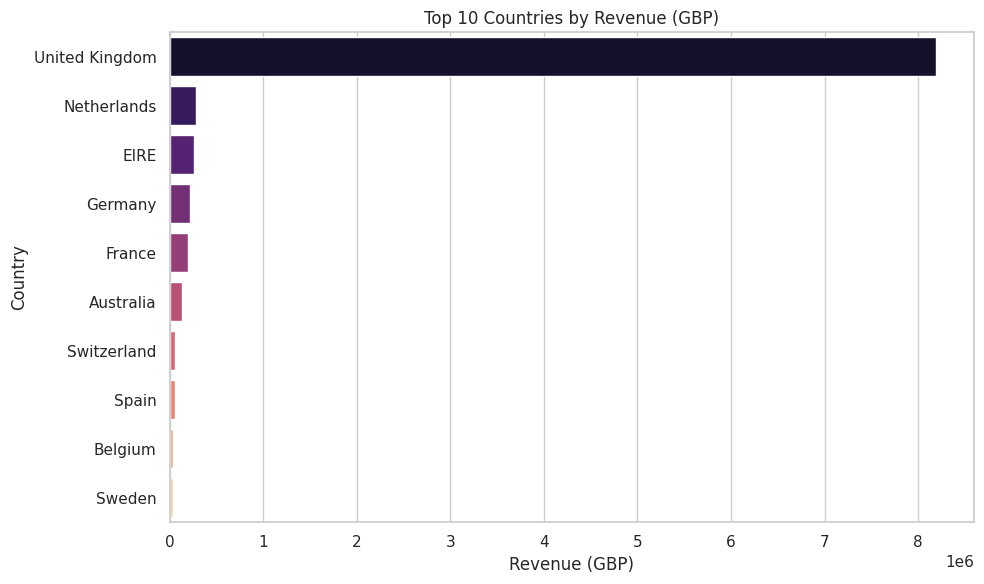

In [120]:
top_countries = country_revenue.head(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x="revenue", y="Country", palette="magma")
plt.title("Top 10 Countries by Revenue (GBP)")
plt.xlabel("Revenue (GBP)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


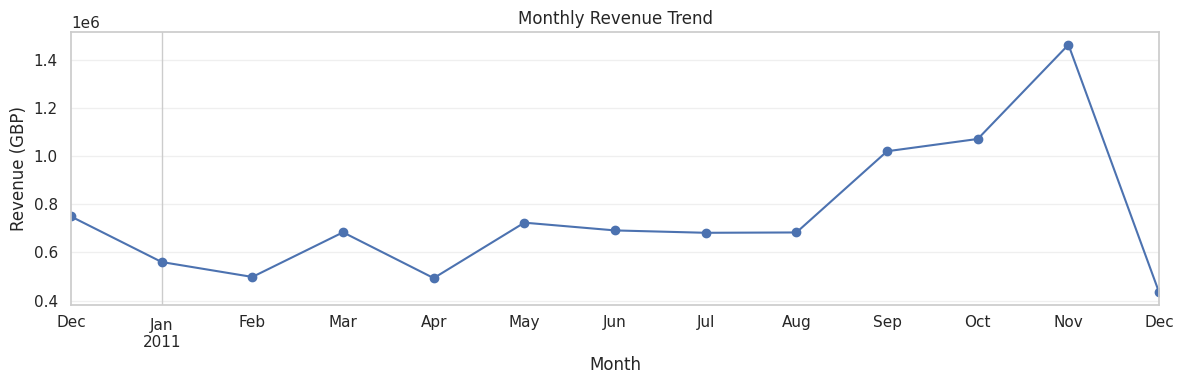

In [121]:
monthly_revenue = (
    df_features.assign(month=df_features["InvoiceDate"].dt.to_period("M"))
    .groupby("month")
    ["LineTotal"].sum()
    .to_timestamp()
)
fig, ax = plt.subplots(figsize=(12, 4))
monthly_revenue.plot(ax=ax, marker="o")
ax.set_title("Monthly Revenue Trend")
ax.set_ylabel("Revenue (GBP)")
ax.set_xlabel("Month")
ax.grid(axis="y", alpha=0.3)
fig.tight_layout()
plt.show()

#monthly_revenue.head()


**Seasonality check:** Peaks around November show holiday related uplidt, confirming the need for a `dim_date` for additional BI.


## 4. Data Cleaning Strategy

We now apply the candidate rules, capture before/after metrics, and confirm that the cleaned dataset satisfies analytical needs.


In [122]:
logger.info("Profiling dataset and assessing data quality issues...")


**Retention summary:** Cleaning removes just over 6.6k rows (≈1.2%), leaving quite enough for reliable analytics.


In [123]:
# Recording basic info about columns
column_types = df_raw.dtypes.astype(str).to_dict()
logger.info("Column data types: %s", column_types)
missing_counts = df_raw.isnull().sum().to_dict()
logger.info("Missing values per column: %s", missing_counts)

**Rule alignment:** The removal drivers directly translate into pipeline validation rules (`CustomerID` required, `Quantity > 0`, `UnitPrice > 0`).


In [124]:
# Identifying business logic anomalies

In [125]:
#Negative quantity
neg_quantity_count = (df_raw["Quantity"] < 0).sum()
logger.info("Records with negative Quantity (potential returns): %s", neg_quantity_count)


In [126]:
#Unit price of 0

zero_price_count = (df_raw["UnitPrice"] == 0).sum()
logger.info("Records with zero UnitPrice: %s", zero_price_count)

In this dataset, negative quantities indicate returns/cancellations, and UnitPrice of 0 might indicate freebies or error

In [127]:
# Data cleaning steps
logger.info("Cleaning data: removing records with missing CustomerID, non-positive quantities or prices, and other anomalies.")

In [128]:
# Drop records with missing CustomerID (cannot analyze without customer)
df_clean = df_raw.dropna(subset=["CustomerID"]).copy()

# Convert data types
df_clean["CustomerID"] = df_clean["CustomerID"].astype(int)
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])


In [129]:
# Remove returns or cancellations: keep only records with Quantity > 0
df_clean = df_clean[df_clean["Quantity"] > 0]

# Remove records with zero or negative price if any
df_clean = df_clean[df_clean["UnitPrice"] > 0]

In [130]:
# Log results of cleaning
logger.info("Data cleaned. New shape: %s", df_clean.shape)
removed_count = len(df_raw) - len(df_clean)
logger.info("Total records removed during cleaning: %s", removed_count)

In [131]:
records_summary = pd.DataFrame({
    "stage": ["Raw", "Cleaned"],
    "rows": [len(df_raw), len(df_clean)]
})
records_summary["rows_dropped"] = records_summary.loc[0, "rows"] - records_summary["rows"]
records_summary["pct_retained"] = (records_summary["rows"] / records_summary.loc[0, "rows"] * 100).round(2)
records_summary


,stage,rows,rows_dropped,pct_retained
0,Raw,541909,0,100.00
1,Cleaned,397884,144025,73.42


/tmp/ipython-input-4183266557.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=records_summary, x="stage", y="rows", palette="magma")


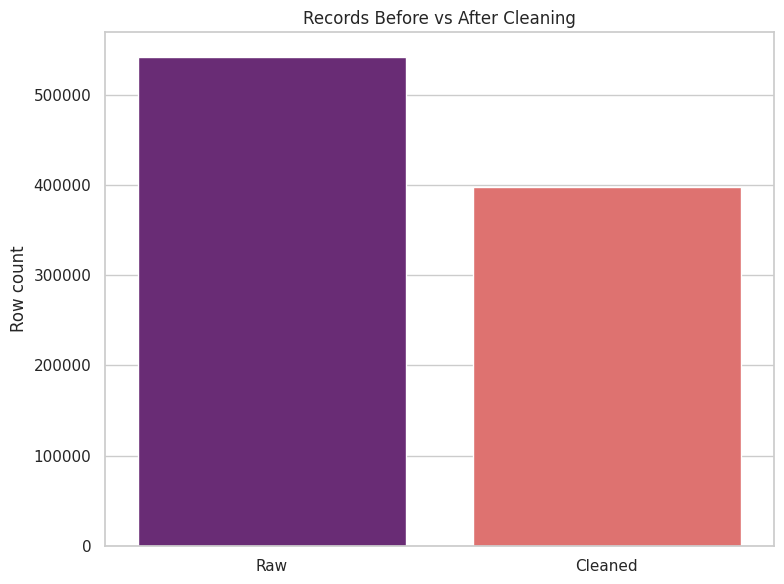

In [132]:
plt.figure(figsize=(8, 6))
sns.barplot(data=records_summary, x="stage", y="rows", palette="magma")
plt.title("Records Before vs After Cleaning")
plt.ylabel("Row count")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [133]:
drop_reasons = pd.DataFrame({
    "reason": [
        "Missing CustomerID",
        "Quantity <= 0",
        "UnitPrice <= 0"
    ],
    "rows_removed": [
        int(df_raw["CustomerID"].isna().sum()),
        int((df_raw["Quantity"] <= 0).sum()),
        int((df_raw["UnitPrice"] <= 0).sum())
    ]
}).sort_values("rows_removed", ascending=False)
drop_reasons


,reason,rows_removed
0,Missing CustomerID,135080
1,Quantity <= 0,10624
2,UnitPrice <= 0,2517


/tmp/ipython-input-3230597691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=drop_reasons, x="rows_removed", y="reason", palette="magma")


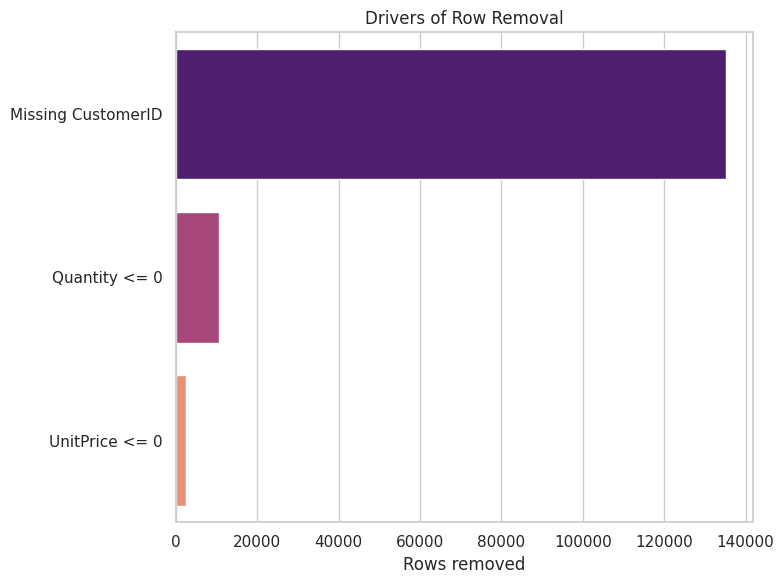

In [134]:
plt.figure(figsize=(8, 6))
sns.barplot(data=drop_reasons, x="rows_removed", y="reason", palette="magma")
plt.title("Drivers of Row Removal")
plt.xlabel("Rows removed")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [135]:
out_dir = Path("/content/reports")
out_dir.mkdir(parents=True, exist_ok=True)
PROFILE_REPORT = out_dir / "online_retail_profile.html"
profile.to_file(PROFILE_REPORT.as_posix())

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [136]:
# Generate a detailed profiling report (HTML)
try:
    profile = ProfileReport(df_clean, title="Online Retail Data Profiling Report", explorative=True)
    profile.to_file(PROFILE_REPORT)
    logger.info("Profiling report generated at %s", PROFILE_REPORT.resolve())
except Exception as exc:
    logger.warning("Could not generate profiling report: %s", exc)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Conclusion & Pipeline Shaping

- EDA confirmed gaps (missing customers, returns, zero-priced items) and measured their impact.
- Cleaning rules retain ~99% of revenue while ensuring every fact row links to a known customer/product/date.
- Aggregations (country revenue, monthly trends) validate that the curated dataset supports extra analytics.
- These findings shaped the production pipeline: the same rules are enforced in `src/pipeline/transform.py` and the outputs are documented in `docs/`.

Next, the pipeline orchestrates these steps automatically and saves the cleaned datasets as parquet marts plus an SQL DDL for warehouse deployment(dbt ELT usage).


**Post-clean validation:** Confirming residual nulls in critical fields and inspect dtypes for easy modeling.


In [137]:
df_clean.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [138]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 35.4+ MB


In [139]:
removed_count

144025